In [1]:
## Prep the workspace
library("AzureML")
ws <- workspace()

## load the data: 2014 arrests by county and agency; county pop by race and gender
dat_arrests <- download.datasets(ws, "ca_doj_arrests_deidentified_2014_05-07-2016.csv")
dat_pop <- download.datasets(ws, "ca_county_population_by_race_gender_age_2005-2014_02-05-2016.csv")

In [2]:
## Preview the arrests data
dim(dat_arrests)
names(dat_arrests)
head(dat_arrests)

[1] 1212845      16

[1] "county"                   "agency_name"             
 [3] "agency_code"              "arrest_year"             
 [5] "arrest_month"             "arrest_day"              
 [7] "race_or_ethnicity"        "gender"                  
 [9] "age_group"                "summary_offense_level"   
[11] "offense_level"            "bcs_offense_code"        
[13] "bcs_summary_offence_code" "fbi_offense_code"        
[15] "status_type"              "disposition"

county                      agency_name agency_code arrest_year arrest_month
1 Alameda Alameda Co. Sheriff's Department        0100        2014            1
2 Alameda Alameda Co. Sheriff's Department        0100        2014            1
3 Alameda Alameda Co. Sheriff's Department        0100        2014            1
4 Alameda Alameda Co. Sheriff's Department        0100        2014            1
5 Alameda Alameda Co. Sheriff's Department        0100        2014            1
6 Alameda Alameda Co. Sheriff's Department        0100        2014            1
  arrest_day race_or_ethnicity gender age_group summary_offense_level
1          1             Black   male     adult           misdemeanor
2          1          Hispanic   male     adult           misdemeanor
3          1          Hispanic   male     adult           misdemeanor
4          1             Black female     adult                felony
5          1             Black   male     adult                felony
6          1             White female     adult           misdemeanor
  offense_level bcs_offense_code bcs_summary_offence_code fbi_offense_code
1   misdemeanor              856                       51               21
2   misdemeanor              856                       51               21
3   misdemeanor              397                       30               08
4        felony              993                       25               26
5        felony              825                       14              18H
6   misdemeanor               98                       59               26
  status_type                  disposition
1      booked misdemeanor complaint sought
2      booked misdemeanor complaint sought
3      booked misdemeanor complaint sought
4      booked      felony complaint sought
5      booked      felony complaint sought
6      booked misdemeanor complaint sought

In [3]:
## Load necessary libraries
library(dplyr)
library(ggplot2)
library(grid)
library(stats)


Attaching package: 'dplyr'

The following object is masked from 'package:stats':

    filter

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [4]:
## Subset arrests to only juveniles.
dat_juv <- dat_arrests[dat_arrests$age_group %in% "juvenile",]

## Group by county, then by year, then by race/ethnicity and give me the counts.
cty_ethnic <- summarise(group_by(dat_juv, county, arrest_year, race_or_ethnicity), total = n())

## Now remove those records supressed due to privacy concern.
cty_ethnic <- cty_ethnic[!(cty_ethnic$race_or_ethnicity %in% "suppressed_due_to_privacy_concern"),]

#### !! Some counties are reporting only "NA"s in their arrest totals per ethnic group. :-\
## Let's remove those from our analysis...for now.
cty_ethnic <- cty_ethnic[!is.na(cty_ethnic$total),]

## Preview
dim(cty_ethnic)
head(cty_ethnic)
tail(cty_ethnic)

[1] 168   4

Source: local data frame [6 x 4]
Groups: county, arrest_year

   county arrest_year      race_or_ethnicity total
1 Alameda        2014 Asian/Pacific Islander   136
2 Alameda        2014                  Black  1011
3 Alameda        2014               Hispanic   702
4 Alameda        2014                  Other    80
5 Alameda        2014                  White   323
6   Butte        2014 Asian/Pacific Islander     8

Source: local data frame [6 x 4]
Groups: county, arrest_year

   county arrest_year      race_or_ethnicity total
1 Ventura        2014                  White   573
2    Yolo        2014 Asian/Pacific Islander     8
3    Yolo        2014                  Black    32
4    Yolo        2014               Hispanic   108
5    Yolo        2014                  Other     5
6    Yolo        2014                  White   117

In [5]:
## Panel bar charts: ethnic breakdown of arrests, by county.
## NOTE: this is before normalizing by ethnic population.
plot_ethnic <- ggplot(cty_ethnic, aes(x = race_or_ethnicity, y = total, fill = race_or_ethnicity)) + 
                geom_bar(stat = "identity") + coord_flip() + facet_wrap(~county) +  
                theme(axis.text.x=element_text(angle=-90,hjust=1,vjust=0.5, size = 8), axis.text.x=element_text(size = 8),
                      legend.position = "none", strip.text=element_text(size = 8), axis.title.x=element_blank(),
                      axis.title.y=element_blank()) +
                ggtitle("Ethnic Breakdown of Arrest FREQ by County")

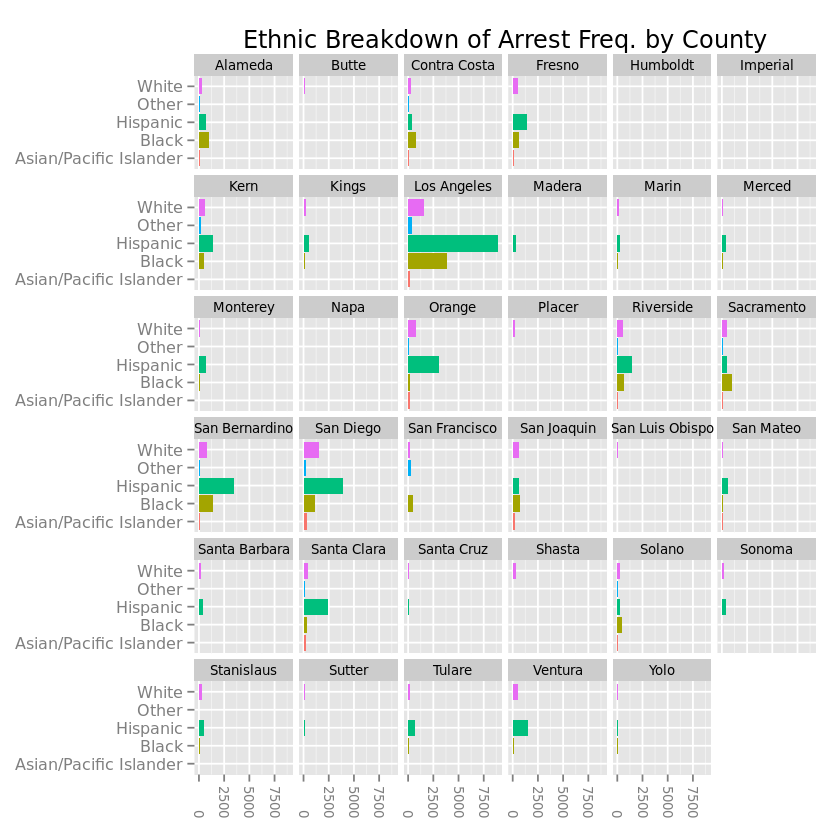

In [6]:
plot_ethnic

In [7]:
## Stacked bar chart: ethnic breakdown of arrests, stacked between counties.
## Again, this is before normalizing by ethnic population.
plot_ethnic2 <- ggplot(cty_ethnic, aes(x = race_or_ethnicity, y = total, fill = county)) + 
                geom_bar(stat = "identity") + coord_flip() + 
                theme(axis.text.x=element_text(angle=-90,hjust=1,vjust=0.5, size = 8), axis.text.x=element_text(size = 8),
                      strip.text=element_text(size = 8), axis.title.x=element_blank(), axis.title.y=element_blank(),
                      legend.text=element_text(size= 6), legend.key.height=unit(.4, "cm")) +
                ggtitle("Cumulative Ethnic Breakdown of Arrests by County")

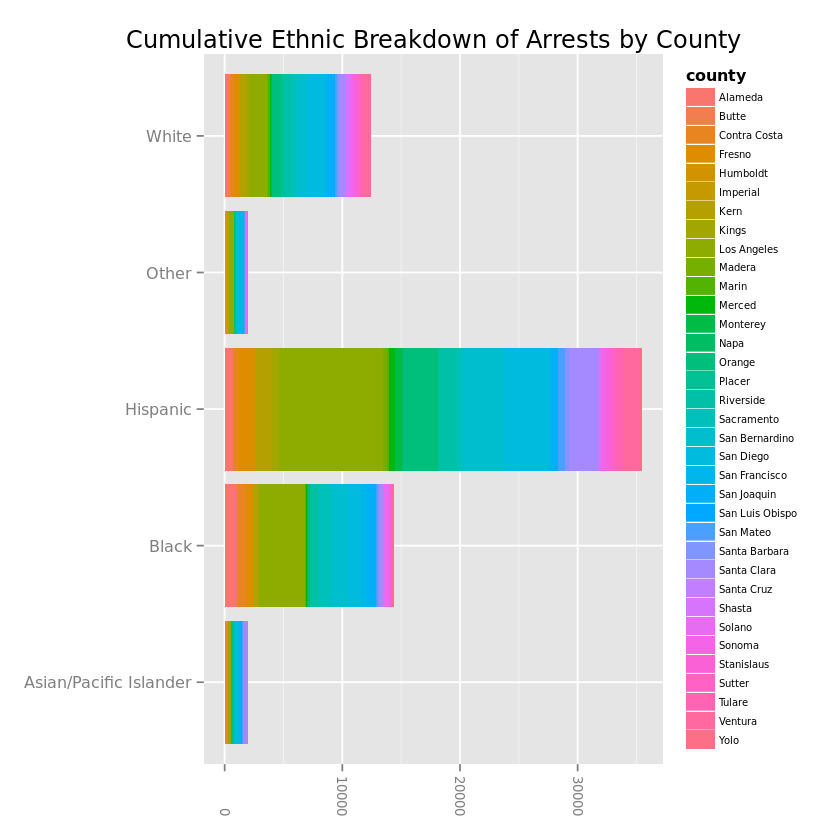

In [8]:
plot_ethnic2

In [9]:
## Now, let's preview the population data
dim(dat_pop)
names(dat_pop)
head(dat_pop)
tail(dat_pop)

[1] 148680      6

[1] "year"       "county"     "race"       "gender"     "age_group" 
[6] "population"

year  county         race       gender    age_group population
1 2005 Alameda All Combined All Combined All Combined    1459881
2 2005 Alameda All Combined All Combined     Juvenile     354877
3 2005 Alameda All Combined All Combined        Adult    1105004
4 2005 Alameda All Combined All Combined          0-9     192318
5 2005 Alameda All Combined All Combined        10-14     101688
6 2005 Alameda All Combined All Combined        15-17      60871

year county  race gender age_group population
148675 2014   Yuba Other   Male     18-24        235
148676 2014   Yuba Other   Male     25-29        102
148677 2014   Yuba Other   Male     30-39        210
148678 2014   Yuba Other   Male     40-49        154
148679 2014   Yuba Other   Male     50-59        142
148680 2014   Yuba Other   Male       60+        148

In [10]:
## Looks like it's already aggregated along a number of dimensions. 
## Let's subset only the juveniles.
dat_pop_jv <- dat_pop[dat_pop$age_group %in% "Juvenile",]
head(dat_pop_jv)

year  county         race       gender age_group population
2  2005 Alameda All Combined All Combined  Juvenile     354877
14 2005 Alameda All Combined       Female  Juvenile     173570
26 2005 Alameda All Combined         Male  Juvenile     181307
38 2005 Alameda     Hispanic All Combined  Juvenile     103616
50 2005 Alameda     Hispanic       Female  Juvenile      50726
62 2005 Alameda     Hispanic         Male  Juvenile      52890

In [11]:
## Ok, now, let's look at arrests of both genders and ignore the 'all combined' county value.
dat_pop_jv <- dat_pop_jv[dat_pop_jv$gender %in% "All Combined" & !(dat_pop_jv$county %in% "All Combined"),]

## Let's also remove the race 'all combined.'
dat_pop_jv <- dat_pop_jv[!(dat_pop_jv$race %in% "All Combined"),]

head(dat_pop_jv[dat_pop_jv$year %in% "2014",])
tail(dat_pop_jv[dat_pop_jv$year %in% "2014",])

year  county                   race       gender age_group population
133850 2014 Alameda               Hispanic All Combined  Juvenile     107250
133886 2014 Alameda                  Black All Combined  Juvenile      38223
133922 2014 Alameda                  White All Combined  Juvenile      81270
133958 2014 Alameda Asian/Pacific Islander All Combined  Juvenile      89431
133994 2014 Alameda        Native American All Combined  Juvenile        783
134030 2014 Alameda                  Other All Combined  Juvenile      26088

year county                   race       gender age_group population
148466 2014   Yuba               Hispanic All Combined  Juvenile       7234
148502 2014   Yuba                  Black All Combined  Juvenile        568
148538 2014   Yuba                  White All Combined  Juvenile      10187
148574 2014   Yuba Asian/Pacific Islander All Combined  Juvenile       1506
148610 2014   Yuba        Native American All Combined  Juvenile        307
148646 2014   Yuba                  Other All Combined  Juvenile       1552

In [12]:
## Looks like we'll have to do some recoding/classification, if we want to look at
## Native American, Other, or suppressed_due_to_privacy_concern populations.
unique(dat_juv$race_or_ethnicity)
unique(dat_pop_jv$race)

[1] "Black"                             "Hispanic"                         
[3] "White"                             "Asian/Pacific Islander"           
[5] "Other"                             "suppressed_due_to_privacy_concern"

[1] "Hispanic"               "Black"                  "White"                 
[4] "Asian/Pacific Islander" "Native American"        "Other"

In [13]:
## Join the pop and arrests datasets.
## Start by relabeling the 'race' variable in the pop table. Also, until we've bound all years together, 
## let's subset pop figures to 2014.
names(dat_pop_jv)[3] <- "race_or_ethnicity"
names(cty_ethnic)[2] <- "year"
dat_joined <- right_join(cty_ethnic, dat_pop_jv[dat_pop_jv$year %in% "2014",], by = c("county","year","race_or_ethnicity"))

In [14]:
## Preview to confirm. 
head(dat_joined[!(dat_joined$county %in% "Alpine" | dat_joined$county %in% "Amador" | dat_joined$county %in% "Yuba"),])
tail(dat_joined[!(dat_joined$county %in% "Alpine" | dat_joined$county %in% "Amador" | dat_joined$county %in% "Yuba"),])

Source: local data frame [6 x 7]

   county year      race_or_ethnicity total       gender age_group population
1 Alameda 2014               Hispanic   702 All Combined  Juvenile     107250
2 Alameda 2014                  Black  1011 All Combined  Juvenile      38223
3 Alameda 2014                  White   323 All Combined  Juvenile      81270
4 Alameda 2014 Asian/Pacific Islander   136 All Combined  Juvenile      89431
5 Alameda 2014        Native American    NA All Combined  Juvenile        783
6 Alameda 2014                  Other    80 All Combined  Juvenile      26088

Source: local data frame [6 x 7]

  county year      race_or_ethnicity total       gender age_group population
1   Yolo 2014               Hispanic   108 All Combined  Juvenile      19981
2   Yolo 2014                  Black    32 All Combined  Juvenile        999
3   Yolo 2014                  White   117 All Combined  Juvenile      16625
4   Yolo 2014 Asian/Pacific Islander     8 All Combined  Juvenile       4069
5   Yolo 2014        Native American    NA All Combined  Juvenile        215
6   Yolo 2014                  Other     5 All Combined  Juvenile       2629

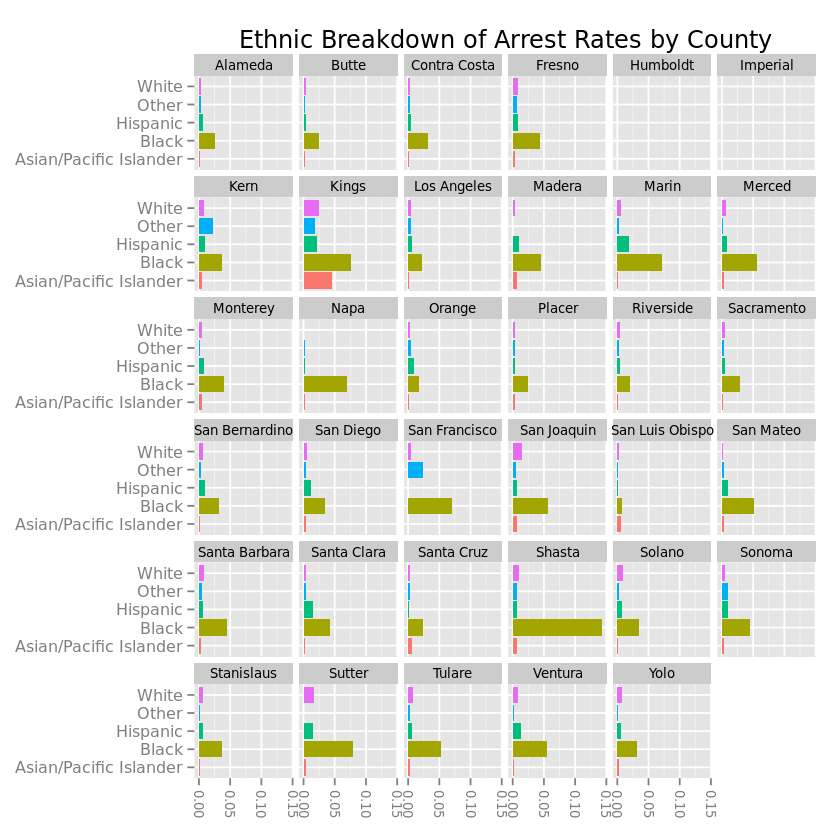

In [15]:
## !! Let's sub out those counties that aren't represented in the arrests file.
dat_joined <- dat_joined[!(dat_joined$county %in% "Alpine" | 
                           dat_joined$county %in% "Amador" |
                           dat_joined$county %in% "Yuba"),]

## Let's remove post-join arrest total NAs from our analysis...for now.
dat_joined <- dat_joined[!is.na(dat_joined$total),]

## Now, let's try that first panel plot, but normalized by population.
plot_ethnic_norm <- ggplot(dat_joined[!(dat_joined$race_or_ethnicity %in% "Native American"),], 
                        aes(x = race_or_ethnicity, y = total/population, fill = race_or_ethnicity), na.rm=T) + 
                        geom_bar(stat = "identity") + coord_flip() + facet_wrap(~county) +  
                        theme(axis.text.x=element_text(angle=-90,hjust=1,vjust=0.5, size = 8), axis.text.x=element_text(size = 8),
                        legend.position = "none", strip.text=element_text(size = 8), axis.title.x=element_blank(),
                        axis.title.y=element_blank()) +
                        ggtitle("Ethnic Breakdown of Arrest Rates by County")

## !! Looks like I'll need to address some out of bound issues when it comes to the Y (see warning).
plot_ethnic_norm

In [16]:
## Add a column just for arrest rate by ethnic population per county.
dat_joined$eth_arrest_rate <- round((dat_joined$total)/(dat_joined$population),5)

## Subset to an ethnic group.
#dat_joined_eth <- dat_joined[dat_joined$race_or_ethnicity %in% "Hispanic",]
dat_joined_eth <- dat_joined[dat_joined$race_or_ethnicity %in% "Black",]
#dat_joined_eth <- dat_joined[dat_joined$race_or_ethnicity %in% "White",]
#dat_joined_eth <- dat_joined[dat_joined$race_or_ethnicity %in% "White",]
#dat_joined_eth <- dat_joined[dat_joined$race_or_ethnicity %in% "Other",]

## Add a column for probability of seeing that arrest rate.
dat_joined_eth$rate_prob <- round(pnorm(dat_joined_eth$eth_arrest_rate, mean(dat_joined_eth$eth_arrest_rate, na.rm = T), 
                              sd(dat_joined_eth$eth_arrest_rate, na.rm = T), lower.tail = FALSE, log.p = FALSE), 5)

## View it all..
dat_joined_eth

Source: local data frame [33 x 9]

         county year race_or_ethnicity total       gender age_group population
1       Alameda 2014             Black  1011 All Combined  Juvenile      38223
2         Butte 2014             Black    17 All Combined  Juvenile        684
3  Contra Costa 2014             Black   747 All Combined  Juvenile      23441
4        Fresno 2014             Black   592 All Combined  Juvenile      13365
5          Kern 2014             Black   479 All Combined  Juvenile      12776
6         Kings 2014             Black   103 All Combined  Juvenile       1354
7   Los Angeles 2014             Black  3861 All Combined  Juvenile     175483
8        Madera 2014             Black    30 All Combined  Juvenile        657
9         Marin 2014             Black    74 All Combined  Juvenile       1032
10       Merced 2014             Black   118 All Combined  Juvenile       2077
..          ...  ...               ...   ...          ...       ...        ...
Variables not shown: eth_arrest_rate (dbl), rate_prob (dbl)

In [17]:
## Calculate z-scores per rate probability.
dat_joined_eth$z_score <- qnorm(dat_joined_eth$rate_prob, lower.tail = FALSE, log.p = FALSE)

## Now, show only those counties whose z-scores are higher than 2...
## ------------------------------------------------------------------

## I.E. These are the counties whose arrest rates of the given ethnicity are statistical 'outliers' 
## among those of their California peer counties. Put another way, their exhibited arrest rates
## have a very low probability of happening purely by chance.
dat_joined_eth[dat_joined_eth$z_score >= 2,]

## IF using t-distribution
## dat_joined_eth[dat_joined_eth$t_score >= 2,]

Source: local data frame [1 x 10]

  county year race_or_ethnicity total       gender age_group population
1 Shasta 2014             Black    58 All Combined  Juvenile        404
Variables not shown: eth_arrest_rate (dbl), rate_prob (dbl), z_score (dbl)


	Shapiro-Wilk normality test

data:  dat_joined_eth$rate_prob
W = 0.9422, p-value = 0.07887


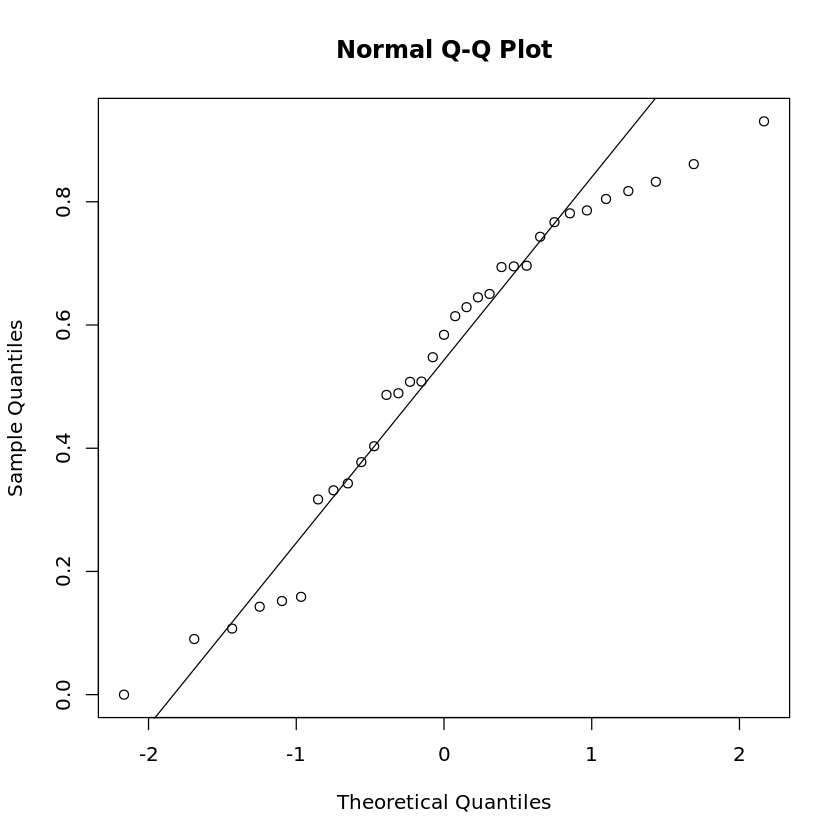

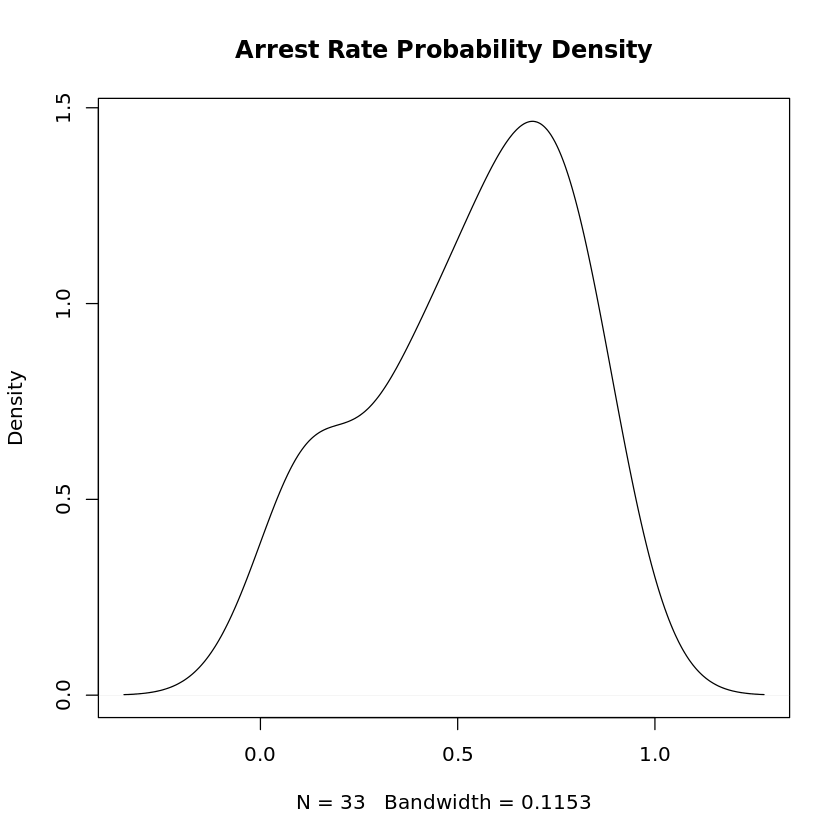

In [25]:
## It'd be a good idea to check whether we're indeed working with a normal distribution, aside from
## our outliers, so let's test that.

## Test for difference between observed distribution and normal distribution (Shapiro-Wilk normality test). 
## If difference's p is < .05, then the observed distribution is not sufficiently normal.
shapiro.test(dat_joined_eth$rate_prob)

## Plot observations against norm quantiles
qqnorm(dat_joined_eth$rate_prob)
qqline(dat_joined_eth$rate_prob)

## Plot the density
plot(density(dat_joined_eth$rate_prob), main = "Arrest Rate Probability Density")

In [19]:
## Ok, great. The distribution problem has been fixed, and our stats are now correct.
## Granted, our population of usable county cases has shrunk by about 40%, but hey,
## it's more important to be accurate here. 

## I'll be extending this to the other ethnic groups and scaling this over the span
## of years we have arrest data for (I believe that's 2005-2014). Then, we'll apply
## this analysis to agencies, too.